# Descrição do problema

Neste projeto temos um conjunto de dados com informações sobre navios de Cruzeiro e o nosso objetivo é desenvolver uma análise capaz de prever a quantidade de membros da tripulação necessária em cada situação.

Os dados apresentam colunas com as seguintes informações:
 
 - Nome do navio
 
 - Nome da companhia
 
 - Idade do navio 
 
 - Capacidade de carregamento (Tonnage)
 
 - N. de passegeiros
 
 - Comprimento
 
 - Cabines
 
 - Densidade de passageiros
 
 - Tripulação

In [1]:
from pyspark.sql import SparkSession

In [2]:
# iniciando uma sessão Spark
spark =  SparkSession.builder.appName('predict_crew').getOrCreate()

22/05/11 20:40:55 WARN Utils: Your hostname, gabriel-ana resolves to a loopback address: 127.0.1.1; using 192.168.0.14 instead (on interface wlp1s0)
22/05/11 20:40:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/05/11 20:40:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
# carragando os dados
data = spark.read.csv('cruise_ship_info.csv', header = True, inferSchema=True)

In [4]:
# verificando os dados
data.show()

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|
|    Ecstasy|   Carnival| 22|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Elation|   Carnival| 15|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Fantasy|   Carnival| 23| 

In [5]:
from pyspark.ml.feature import StringIndexer

In [6]:
# indexando a coluna "Cruise_line" para que essa variável seja levada em conta na modelagem
indexer = StringIndexer(inputCol="Cruise_line", outputCol="Cruise_line_index").fit(data)

In [7]:
data_ind = indexer.transform(data)

In [8]:
data_ind.show()

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+-----------------+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|Cruise_line_index|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+-----------------+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|             16.0|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|             16.0|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|              1.0|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|              1.0|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|              1.0|
|    Ecstasy|   Carnival| 22|            70.367|     20.52|  8.55|  10.2|       

In [9]:
data_ind.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)
 |-- Cruise_line_index: double (nullable = false)



In [13]:
# importando a biblioteca de regressão linear do pyspark
from pyspark.ml.regression import LinearRegression

In [14]:
from pyspark.ml.feature import VectorAssembler 

In [15]:
# agrupando as variáveis que serão utilizadas na modelagem
assembler = VectorAssembler(inputCols=['Age', 'Tonnage', 'passengers', 'length', 
                                       'cabins', 'passenger_density', 'Cruise_line_index'],
                           outputCol='features')

In [16]:
output = assembler.transform(data_ind)

In [17]:
final_data = output.select('features', 'crew')

In [18]:
final_data.show()

+--------------------+----+
|            features|crew|
+--------------------+----+
|[6.0,30.276999999...|3.55|
|[6.0,30.276999999...|3.55|
|[26.0,47.262,14.8...| 6.7|
|[11.0,110.0,29.74...|19.1|
|[17.0,101.353,26....|10.0|
|[22.0,70.367,20.5...| 9.2|
|[15.0,70.367,20.5...| 9.2|
|[23.0,70.367,20.5...| 9.2|
|[19.0,70.367,20.5...| 9.2|
|[6.0,110.23899999...|11.5|
|[10.0,110.0,29.74...|11.6|
|[28.0,46.052,14.5...| 6.6|
|[18.0,70.367,20.5...| 9.2|
|[17.0,70.367,20.5...| 9.2|
|[11.0,86.0,21.24,...| 9.3|
|[8.0,110.0,29.74,...|11.6|
|[9.0,88.5,21.24,9...|10.3|
|[15.0,70.367,20.5...| 9.2|
|[12.0,88.5,21.24,...| 9.3|
|[20.0,70.367,20.5...| 9.2|
+--------------------+----+
only showing top 20 rows



In [41]:
# divide os dados entre treino e teste
train_data, test_data = final_data.randomSplit([0.7, 0.3])

In [42]:
# modelo de regressão linear
lr = LinearRegression(labelCol=('crew'))

In [43]:
# ajusta o modelo nos dados de treino
lr_model = lr.fit(train_data)

22/05/11 20:54:35 WARN Instrumentation: [34cbb254] regParam is zero, which might cause numerical instability and overfitting.


In [44]:
# aplica o modelo nos dados de teste
test_results = lr_model.evaluate(test_data)

In [45]:
# calcula o erro quadrático médio
test_results.rootMeanSquaredError

0.633817137865567

In [46]:
# calcula o r-quadrado
test_results.r2

0.9559110657123155

In [47]:
final_data.describe().show()

+-------+-----------------+
|summary|             crew|
+-------+-----------------+
|  count|              158|
|   mean|7.794177215189873|
| stddev|3.503486564627034|
|    min|             0.59|
|    max|             21.0|
+-------+-----------------+



O valor de r-quadrado indica que o modelo de regressão linear se ajusta muito bem aos dados. Além disso o RMSE é relativamente pequeno, uma vez que o número médio da tripulação é de 7.79.

## Verificando as correlações entre variáveis

In [51]:
from pyspark.ml.stat import Correlation

In [49]:
# agrupando as variáveis para calcular as correlações
assembler2 = VectorAssembler(inputCols=['Age', 'Tonnage', 'passengers', 'length', 
                                       'cabins', 'passenger_density', 'Cruise_line_index', 'crew'],
                           outputCol='corr_features')

In [57]:
myGraph_vector = assembler2.transform(data_ind).select('corr_features')
matrix = Correlation.corr(myGraph_vector, 'corr_features').collect()[0][0]
corrmatrix = matrix.toArray().tolist()

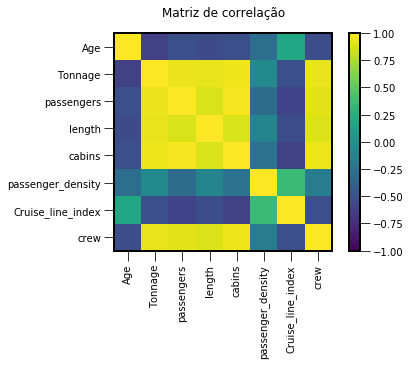

In [72]:
import matplotlib.pyplot as plt

attr = ['Age', 'Tonnage', 'passengers', 'length', 'cabins', 'passenger_density', 'Cruise_line_index', 'crew']

fig=plt.figure()
ax=fig.add_subplot(111)
ax.set_title("Matriz de correlação")
ax.set_xticklabels(['']+attr, rotation = 'vertical')
ax.set_yticklabels(['']+attr)
cax=ax.matshow(corrmatrix,vmax=1,vmin=-1)
fig.colorbar(cax)
ax.xaxis.set_ticks_position('bottom')
plt.show()


O número de tripulantes é fortemente correlacionado com as variáveis: "Tonnage", "passengers", "length" e "cabins". Isso faz com que o modelo de regressão linear forneça bons resultados.